In [1]:
%load_ext autoreload
%autoreload 2

import pprint
import yaml

import numpy as np
import matplotlib.pyplot as plt

import torch
from src.masks.multiblock import MaskCollator as MBMaskCollator

from src.datasets.ukbb import make_ukbb

from src.transforms import make_transforms


In [5]:
with open("configs.yaml", 'r') as y_file:
        args = yaml.load(y_file, Loader=yaml.FullLoader)
        pp = pprint.PrettyPrinter(indent=4)

# -- DATA
rescale_sigma = args['data']['rescale_sigma']
ftsurrogate = args['data']['ftsurrogate']
jitter = args['data']['jitter']
spec_augment = args['data']['spec_augment']
time_flip = args['data']['time_flip']
sign_flip = args['data']['sign_flip']
# --
batch_size = args['data']['batch_size']
pin_mem = args['data']['pin_mem']
num_workers = args['data']['num_workers']
root_path = args['data']['root_path']
image_folder = args['data']['data_path']
val_folder = args['data']['val_path']
crop_size = args['data']['crop_size']
crop_scale = args['data']['crop_scale']
# --

# -- MASK
allow_overlap = args['mask']['allow_overlap']  # whether to allow overlap b/w context and target blocks
patch_size = args['mask']['patch_size']  # patch-size for model training
num_enc_masks = args['mask']['num_enc_masks']  # number of context blocks
min_keep = args['mask']['min_keep']  # min number of patches in context block
enc_mask_scale = args['mask']['enc_mask_scale']  # scale of context blocks
num_pred_masks = args['mask']['num_pred_masks']  # number of target blocks
pred_mask_scale = args['mask']['pred_mask_scale']  # scale of target blocks
aspect_ratio = args['mask']['aspect_ratio']  # aspect ratio of target blocks
# --    
# -- make data transforms
mask_collator = MBMaskCollator(
    input_size=crop_size,
    patch_size=patch_size,
    pred_mask_scale=pred_mask_scale,
    enc_mask_scale=enc_mask_scale,
    aspect_ratio=aspect_ratio,
    nenc=num_enc_masks,
    npred=num_pred_masks,
    allow_overlap=allow_overlap,
    min_keep=min_keep)

transform = make_transforms(
    crop_resizing=crop_size,
    ftsurrogate=ftsurrogate,
    jitter=jitter,
    rescale_sigma=rescale_sigma,
    time_flip=time_flip,
    sign_flip=sign_flip,
    spec_augment = spec_augment
    )

# -- init data-loaders/samplers
_, unsupervised_loader, dist_sampler = make_ukbb(#, unsupervised_sampler = make_mimic(
        transform=None,
            batch_size=batch_size,
            collator=mask_collator,
            pin_mem=pin_mem,
            training=True,
            num_workers=num_workers,
            world_size=1,
            rank=0,
            root_path=root_path,
            data_file=image_folder,
            copy_data=False,
            drop_last=True)

iter = enumerate(unsupervised_loader)

In [6]:
enumerate(unsupervised_loader)

In [7]:
def plot_ecg(signal, mask=None):
    
    _, axs = plt.subplots(len(signal), figsize=(10, 5))

    for i,channel in enumerate(signal):
        if mask is not None:
            axs[i].plot(channel*mask[i])
        else:
            axs[i].plot(channel)

    plt.show()

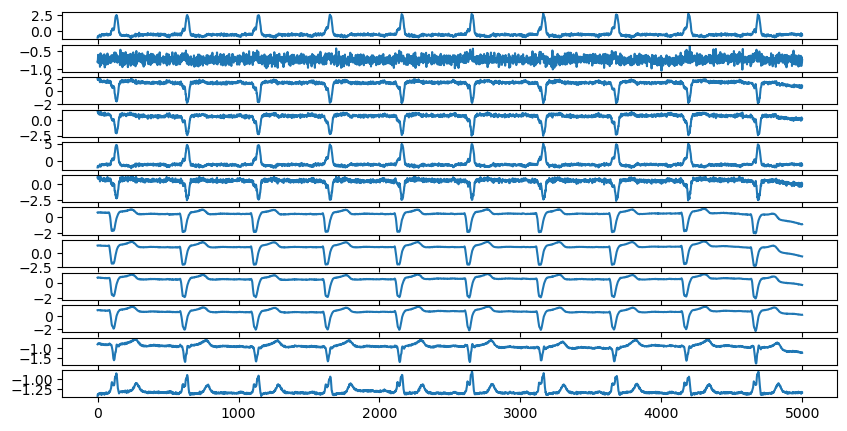

encoder mask 0


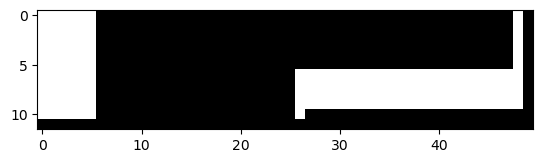

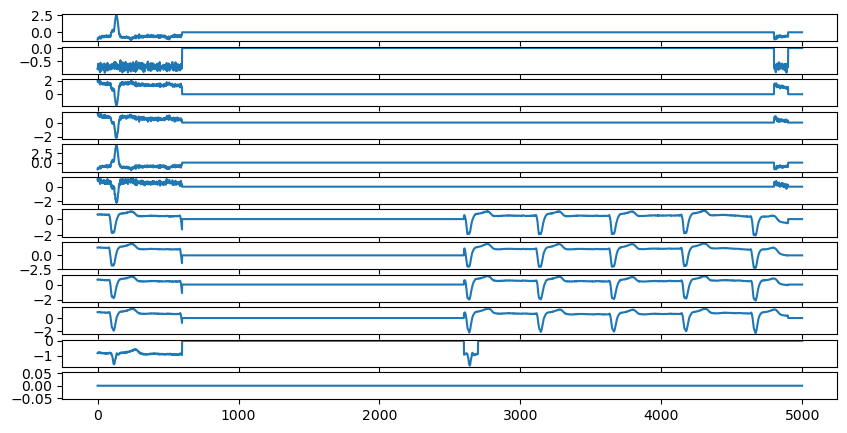

predictor mask 0


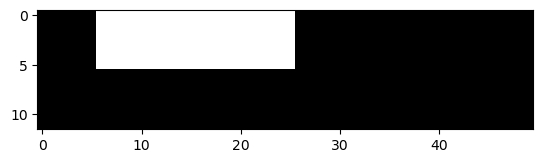

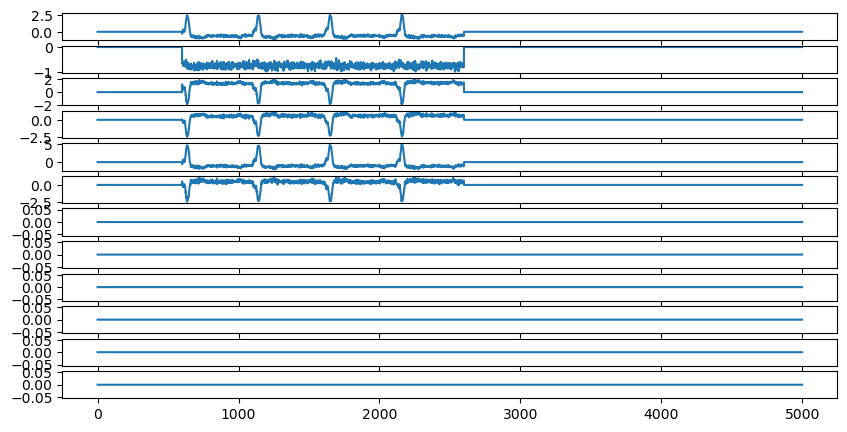

predictor mask 1


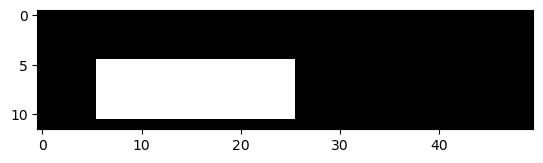

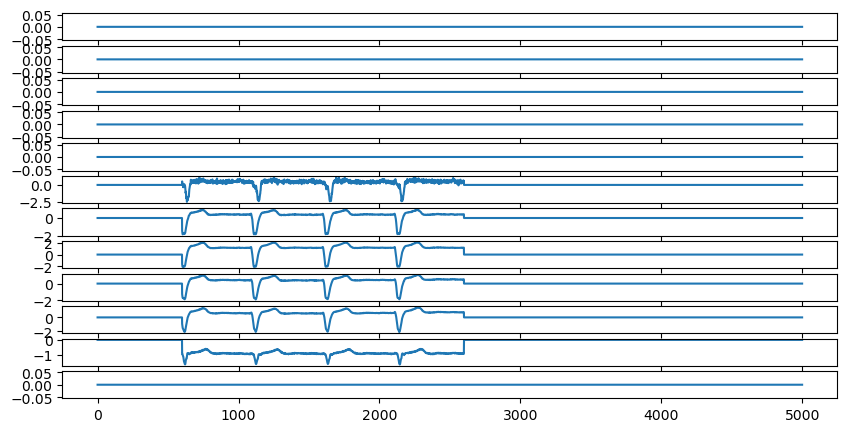

predictor mask 2


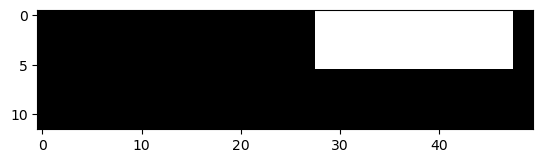

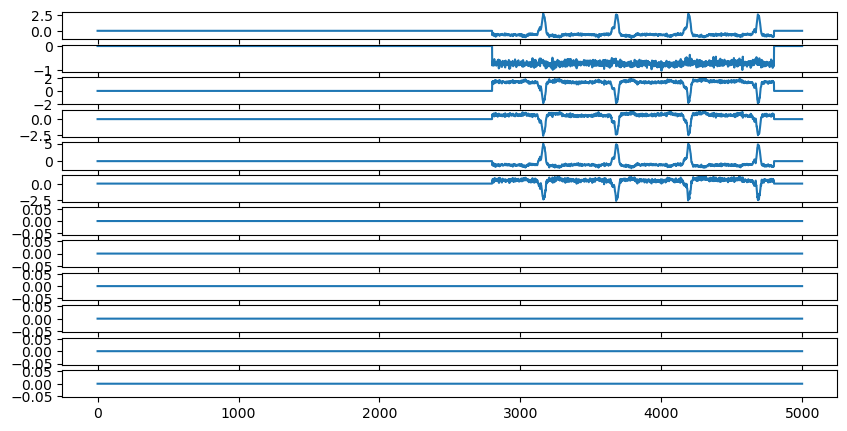

predictor mask 3


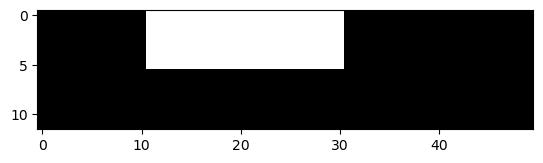

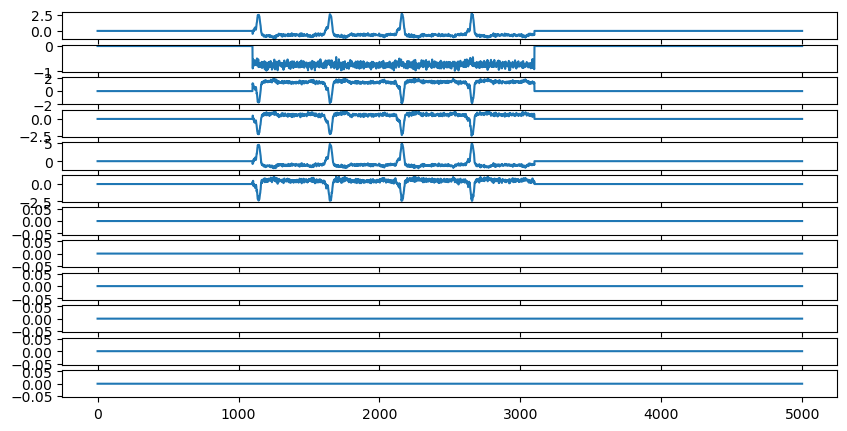

In [9]:
itr, (udata, masks_enc, masks_pred) = next(iter)
signal, target = udata
signal = signal[0].squeeze()
plot_ecg(signal)
plt.show()

for i, x in enumerate(masks_enc):

    print(f'encoder mask {i}')
    mask_enc_full = torch.zeros(600)

    mask_enc_full[x[0]] = 1

    mask_enc_full = mask_enc_full.reshape(12,50)
    
    plt.imshow(mask_enc_full,cmap="gray")
    plt.show()

    mask_enc_full = np.repeat(mask_enc_full,100,axis=1)
    
    
    plot_ecg(signal, mask_enc_full)
    

for i, x in enumerate(masks_pred):
    print(f'predictor mask {i}')

    mask_enc_full = torch.zeros(600)

    mask_enc_full[x[0]] = 1


    mask_enc_full = mask_enc_full.reshape(12,50)
    plt.imshow(mask_enc_full,cmap="gray")
    mask_enc_full = np.repeat(mask_enc_full,100,axis=1)

    plot_ecg(signal, mask_enc_full)